# Frequentist AlexNet performance metrics on MNIST

Sources: 

Kwon et al: *Uncertainty quantification using Bayesian neural
networks in classification: Application to ischemic
stroke lesion segmentation*

Kendall & Gal: *What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?*

Gal & Ghahramani: *Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning*


This code trains a PyTorch NN on MNIST, then incorporates dropout at test-time as in Gal & Ghahramani (2016) to estimate class-specific predictive probabilities and the variance across the *T* models making predictions. It also uses the aleatoric and epistemic uncertainties from Kendall & Gal (2017) and Kwon et al (2018). 


In [0]:
#!git clone https://github.com/kumar-shridhar/PyTorch-BayesianCNN.git

# @article{shridhar2019comprehensive,
#   title={A comprehensive guide to bayesian convolutional neural network with variational inference},
#   author={Shridhar, Kumar and Laumann, Felix and Liwicki, Marcus},
#   journal={arXiv preprint arXiv:1901.02731},
#   year={2019}
# }

Cloning into 'PyTorch-BayesianCNN'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 1375 (delta 220), reused 314 (delta 154), pack-reused 991
Receiving objects: 100% (1375/1375), 67.75 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (821/821), done.
time: 13.5 s


In [69]:
%cd PyTorch-BayesianCNN
!ls

[Errno 2] No such file or directory: 'PyTorch-BayesianCNN'
/content/PyTorch-BayesianCNN/PyTorch-BayesianCNN
checkpoints	       experiments  main_bayesian.py	 README.md
config_bayesian.py     __init__.py  main_frequentist.py  tests
config_frequentist.py  layers	    metrics.py		 utils.py
data		       LICENSE	    models		 visualize_mean_var.py
time: 3.22 s


In [70]:
import PIL
import torch, torchvision
if torchvision.__version__ == "0.5.0":
  #!pip uninstall torchvision
  !pip install torchvision==0.4.2
if PIL.__version__ == "7.0.0":
  #!pip uninstall pillow
  !pip install pillow==6.2.0

print(torchvision.__version__)
print(PIL.__version__)

#!pip install ipython-autotime
%load_ext autotime

0.6.0+cu101
6.2.0
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.03 ms


# Training

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
import PIL
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torch.optim import Adam
from __future__ import print_function

import os
import argparse
import metrics


import numpy as np
from numpy import median
from numpy import percentile
import data
import config_frequentist as cfg
from models.NonBayesianModels.AlexNet import AlexNet
from models.NonBayesianModels.LeNet import LeNet
from models.NonBayesianModels.ThreeConvThreeFC import ThreeConvThreeFC

# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#epochs
N_EPOCHS = 5

# how many times to apply drop-out at test time
T = 10

# net architecture?
net_type = 'alexnet'
# note: alexnet more problematic than lenet
# dataset of choice?
dataset ='MNIST'

def getModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return LeNet(outputs, inputs)
    elif (net_type == 'alexnet'):
        return AlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return ThreeConvThreeFC(outputs, inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def avg_diff_in_lists(list1, list2):
  import numpy as np
  difference = []
  zip_object = zip(list1, list2)
  for list1_i, list2_i in zip_object:
      difference.append(list1_i-list2_i)
  return np.mean(difference)

def enable_dropout(m):
  for each_module in m.modules():
    if each_module.__class__.__name__.startswith('Dropout'):
      each_module.train()


def predict(model, image, label, T=T):
    '''
    Custom function to run dropout T times at test-time.

    '''
    enable_dropout(model)
    # prepare label
    #label = label.item() 
    # prepare image
    #image = image.flatten()
    #image
    standard_output = model(image)
    #print(standard_output.shape)
    standard_prediction = np.argmax(np.array(standard_output.detach().cpu()))
    
    model.train()
    # each vector will consist of T elements- the pre-activation prediction from each model
    zero_p_hat= []
    one_p_hat= []
    two_p_hat= []
    three_p_hat= []
    four_p_hat= []
    five_p_hat= []
    six_p_hat= []
    seven_p_hat= []
    eight_p_hat= []
    nine_p_hat= []

    # predict stochastic dropout model T times
    for t in range(T):
        enable_dropout(model)
        output = model(Variable(image))
        output = output.detach().cpu()
        #print(np.array(output)[0][0])  ############


        zero_p_hat.append(np.array(output)[0][0]) 
        one_p_hat.append(np.array(output)[0][1]) 
        two_p_hat.append(np.array(output)[0][2]) 
        three_p_hat.append(np.array(output)[0][3]) 
        four_p_hat.append(np.array(output)[0][4]) 
        five_p_hat.append(np.array(output)[0][5]) 
        six_p_hat.append(np.array(output)[0][6]) 
        seven_p_hat.append(np.array(output)[0][7]) 
        eight_p_hat.append(np.array(output)[0][8]) 
        nine_p_hat.append(np.array(output)[0][9]) 

    
    zero_var = np.var(zero_p_hat)
    one_var = np.var(one_p_hat)
    two_var = np.var(two_p_hat)
    three_var = np.var(three_p_hat)
    four_var = np.var(four_p_hat)
    five_var = np.var(five_p_hat)
    six_var = np.var(six_p_hat)
    seven_var = np.var(seven_p_hat)
    eight_var = np.var(eight_p_hat)
    nine_var = np.var(nine_p_hat)
    
    # will be a list of 10 elements, the variance of each class's predictions across T models
    class_specific_uncertainties = [zero_var, one_var, two_var, three_var, four_var, five_var, six_var, seven_var, eight_var, nine_var]
    #print(class_specific_uncertainties)
    variance_of_class_specific_predictions = class_specific_uncertainties[label]
    
    # estimate uncertainties (eq. 4 )
    # eq.4 in https://openreview.net/pdf?id=Sk_P2Q9sG
    # see https://github.com/ykwon0407/UQ_BNN/issues/1
    #p_hat_lists = [zero_p_hat, one_p_hat, two_p_hat, three_p_hat, four_p_hat, five_p_hat, six_p_hat, seven_p_hat, eight_p_hat, nine_p_hat]
    #epistemic, aleatoric = uncertainties(np.array(p_hat_lists[label]))
    #print(standard_prediction)
    return standard_prediction.item(), variance_of_class_specific_predictions#, np.squeeze(epistemic), np.squeeze(aleatoric)#, p_hat_lists[label]

def train_model(net, optimizer, criterion, train_loader):
    train_loss = 0.0
    net.train()
    total_train = 0
    correct_train = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

        # accuracy
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += predicted.eq(target.data).sum().item()
        train_accuracy = 100 * correct_train / total_train

    return train_loss, train_accuracy #make this return accuracy


def validate_model(net, criterion, valid_loader):
    valid_loss = 0.0
    #net.eval() 
    net.train() #to keep dropout on
    total_valid = 0
    correct_valid = 0
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

        # accuracy
        _, predicted = torch.max(output.data, 1)
        total_valid += target.size(0)
        correct_valid += predicted.eq(target.data).sum().item()
        valid_accuracy = 100 * correct_valid / total_valid

    return valid_loss, valid_accuracy #make this return accuracy


def run(dataset, net_type):

    # Hyper Parameter settings
    n_epochs = N_EPOCHS 
    lr = 0.01
    num_workers = 4
    valid_size = 0.2
    batch_size = 32

    trainset, testset, inputs, outputs = data.getDataset(dataset)
    train_loader, valid_loader, _ = data.getDataloader(
        trainset, testset, valid_size, batch_size, num_workers)
    net = getModel(net_type, inputs, outputs).to(device)

    ckpt_dir = f'checkpoints/{dataset}/frequentist'
    ckpt_name = f'checkpoints/{dataset}/frequentist/model_{net_type}.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(net.parameters(), lr=lr)
    valid_loss_min = np.Inf
    train_loss_list = []
    valid_loss_list = []
    train_accuracy_list = []
    valid_accuracy_list = []
    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_model(net, optimizer, criterion, train_loader)
        train_accuracy_list.append(train_accuracy)
        valid_loss, valid_accuracy = validate_model(net, criterion, valid_loader)
        valid_accuracy_list.append(valid_accuracy)


        train_loss = train_loss/len(train_loader.dataset)
        train_loss_list.append(train_loss)
        valid_loss = valid_loss/len(valid_loader.dataset)
        valid_loss_list.append(valid_loss)
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch, train_loss, train_accuracy/100., valid_loss, valid_accuracy/100.))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_min = valid_loss
    return train_accuracy_list, valid_accuracy_list, train_loss_list, valid_loss_list, net, criterion, testset, n_epochs, ckpt_name


time: 407 ms


Training.....
Epoch: 0 	Training Loss: 1.873488 	Training Accuracy: 0.109687 	Validation Loss: 0.460346 	Validation Accuracy: 0.100417
Validation loss decreased (inf --> 0.460346).  Saving model ...
Epoch: 1 	Training Loss: 1.841872 	Training Accuracy: 0.108896 	Validation Loss: 0.460397 	Validation Accuracy: 0.112750
Epoch: 2 	Training Loss: 1.842286 	Training Accuracy: 0.110062 	Validation Loss: 0.460307 	Validation Accuracy: 0.112750
Validation loss decreased (0.460346 --> 0.460307).  Saving model ...
Epoch: 3 	Training Loss: 1.842045 	Training Accuracy: 0.109854 	Validation Loss: 0.460461 	Validation Accuracy: 0.112750
Epoch: 4 	Training Loss: 1.842206 	Training Accuracy: 0.109417 	Validation Loss: 0.460376 	Validation Accuracy: 0.112750
----------------------------------Training done-------------------------------------------------
Training accuracy is 	10.941666666666666
 Validation accuracy is 	11.275
Testing..........
----------------------------------Testing done--------------

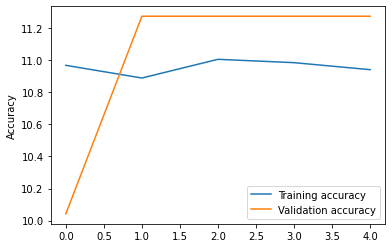

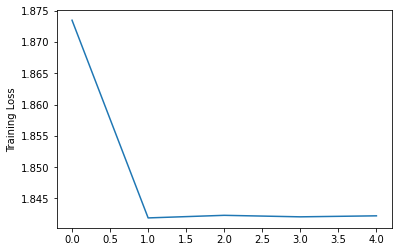

time: 7min 41s


In [73]:
if __name__ == '__main__':
    print("Training.....")
    crit_t_statistic=2.262156 # t statistic with n-1 = 10-1 = 9 since pop. std. deviation unknown
    # for distribution-free confidence intervals:
    alpha = 5.0
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)


    parser = argparse.ArgumentParser(description = "PyTorch Frequentist Model Training")
    parser.add_argument('--net_type', default=net_type, type=str, help='model')
    parser.add_argument('-f')
    parser.add_argument('--dataset', default=dataset, type=str, help='dataset = [MNIST/CIFAR10/CIFAR100]')
    args = parser.parse_args()

    # return all training/validation metrics
    train_accuracy_list, valid_accuracy_list, train_loss_list, valid_loss_list, net_trained, criterion, testset, n_epochs, ckpt_name = run(args.dataset, args.net_type)
    print("----------------------------------Training done-------------------------------------------------")
    print("Training accuracy is \t{}\n Validation accuracy is \t{}".format(train_accuracy_list[-1], valid_accuracy_list[-1]))
    print("Testing..........")
    # return all test metrics
    correct = 0
    total = 0
    test_batch_size = 1 # test image-wise. Average accuracy across entire test-set is conceptually equivalent
    # to averaging across batch accuracies.

    test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, 
            num_workers=4) # use testset from run function, no data leakage
    net_trained.load_state_dict(torch.load(ckpt_name)) # load trained network

    accuracy_runs = []
    epistemic_runs = []
    aleatoric_runs = []
    variance_runs = [] # this is average 
    
    for j, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        #print(labels)
        # predicted, var_uncertainty, epistemic, aleatoric = predict(net_trained, images, labels)
        predicted, var_uncertainty = predict(net_trained, images, labels)
        #predicted = net_trained(images)
        #predicted = np.argmax(np.array(predicted.detach()))
        total += labels.size(0)
        labels = np.array(labels.cpu()) #must be cast to np.array() so that the comparison can be made between this and 'predicted' when counting correct preditions..
        correct += (predicted == labels).sum().item()
        accuracy_runs.append(100 * correct / total)
        # epistemic_runs.append(epistemic)
        # aleatoric_runs.append(aleatoric)
        variance_runs.append(var_uncertainty)
    print("----------------------------------Testing done-------------------------------------------------")
    print("TEST METRICS:")
    avg_test_accuracy = np.mean(accuracy_runs)
    # avg_test_epistemic = np.mean(epistemic_runs)
    # avg_test_aleatoric = np.mean(aleatoric_runs)
    avg_test_variance = np.mean(variance_runs)
    # standard deviation of test accuracies across the 10 sampled networks with dropout
    sd_runs = np.sqrt(avg_test_variance)
    
    # generalization gap b/w train and test, and train and valid
    train_test_gg = train_accuracy_list[-1]-avg_test_accuracy
    train_valid_gg = avg_diff_in_lists(train_accuracy_list[1:], valid_accuracy_list[1:])
    median_test_accuracy = median(accuracy_runs)
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(accuracy_runs, lower_p))
    # retrieve observation at upper percentile
    upper = min(1.0, percentile(accuracy_runs, upper_p))


    margin = crit_t_statistic*sd_runs/np.sqrt(T)/100
    avg_test_accuracy_ratio = avg_test_accuracy/100
    
    print("On average, the training-valid. generalization gap is \t{}\n After training, the training-test generalization gap is \t{}".format(train_valid_gg, train_test_gg))
    print("For a frequentist {} CNN on the {} dataset with {} epochs, \nThe 95% confidence interval on mean test-set accuracy across {} runs is \t{} +/- {}".format(net_type, dataset, n_epochs, T, avg_test_accuracy_ratio, margin))
    print("Median test accuracy is {}. The 95% dist'n-free confidence interval is ({},{})".format(median_test_accuracy, lower, upper))


    import matplotlib.pyplot as plt
    plt.plot(train_accuracy_list)
    plt.plot(valid_accuracy_list)
    plt.ylabel('Accuracy')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
    plt.show()


    import matplotlib.pyplot as plt
    plt.plot(train_loss_list)
    plt.ylabel('Training Loss')
    plt.show()



Note that the above output demonstrates the network 'getting stuck'. 
It would require a manual restart until it finds its way.

# For 5 epochs:

- For a frequentist alexnet CNN on the MNIST dataset with 5 epochs, The 95% confidence interval on mean test-set accuracy across 10 applications of dropout is 0.6646875893505383 +/- 0.021580493480724487, 0.762512079178505 +/- 0.0420700091605942

- time: 42.6 s, testing time: 5min 36s. time: 44.5 s, testing time: 5min 17s

- For 5 epochs, the average train-validation GG is 0.10041145833333336, -0.08554687499999998	

- For 5 epochs, the train-test GG is -0.01341675601720496, 0.01782125415482824	

- 50th percentile (median) = 66.324, 75.990

- 2.5th percentile = 64.628, 73.889

- 97.5th percentile = 1.000, 1.000

# For 10 epochs:

- For a frequentist alexnet CNN on the MNIST dataset with 10 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 runs is 	0.7737695777130047 +/- 0.03662733525452743, 0.8218981568584716 +/- 0.038536765568285156

- time: 1min 28s, testing time: 5min 21s. time: 1min 28s, testing time: 5min, 17s

- For 10 epochs, the average train-validation GG is -0.08252546296296297, -0.02507407407407406	

- For 10 epochs, the train-test GG is 0.012417922286995377, 0.019185176474861832

- 50th percentile (median) = 75.990, 82.251

- 2.5th percentile = 73.889, 80.819

- 97.5th percentile = 1.000, 1.000

# For 15 epochs:

- For a frequentist alexnet CNN on the MNIST dataset with 15 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 runs is 	0.858377269542601 +/- 0.05702292327613694

- time: 2min 12s, testing time: 5min 15s

- For 15 epochs, the average train-validation GG is -0.011090773809523802

- For 15 epochs, the train-test GG is 0.006581063790732458

- 50th percentile (median) = 85.472

- 2.5th percentile = 83.878

- 97.5th percentile = 1.000

# For 20 epochs:

- For a frequentist alexnet CNN on the MNIST dataset with 20 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 runs is 	0.8054430450318588 +/- 0.054124585081560775

- time: 2min 57s, testing time: 5min 25s

- For 20 epochs, the average train-validation GG is -0.008445175438596478

- For 20 epochs, the train-test GG is 0.014681954968141184

- 50th percentile (median) = 80.391

- 2.5th percentile = 78.914

- 97.5th percentile = 1.000

# For 25 epochs:

- For a frequentist alexnet CNN on the MNIST dataset with 25 epochs, 
The 95% confidence interval on mean test-set accuracy across 10 runs is  0.8447238270787482 +/- 0.03871579299478606

- time: 3min 44s, testing time: 5min 34s

- For 25 epochs, the average train-validation GG is -0.001473090277777794	

- For 25 epochs, the train-test GG is  0.0128386729212518	

- 50th percentile (median) = 84.362

- 2.5th percentile = 83.192

- 97.5th percentile = 1.000
